<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/PredictStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [2]:
#import packages
from IPython.display import display
import pandas as pd
import numpy as np

import datetime as dt
import pandas_datareader.data  as pdr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

sns.set()
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.2)

Using TensorFlow backend.


In [0]:
def MACD(close_price, fast=12, slow=26, signal=9):
    ma_fast = close_price.ewm(span=fast, min_periods=fast).mean()
    ma_slow = close_price.ewm(span=slow, min_periods=slow).mean()
    macd = ma_fast - ma_slow
    ma_signal = macd.ewm(span=signal, min_periods=signal).mean()
    return (macd, ma_signal)

In [0]:
ticker = "IBM"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(365 * 5)
data = pdr.get_data_yahoo(ticker, start_date, end_date) 
data['MACD'], data['Signal'] = MACD(data['Adj Close'])
data.dropna(inplace=True)

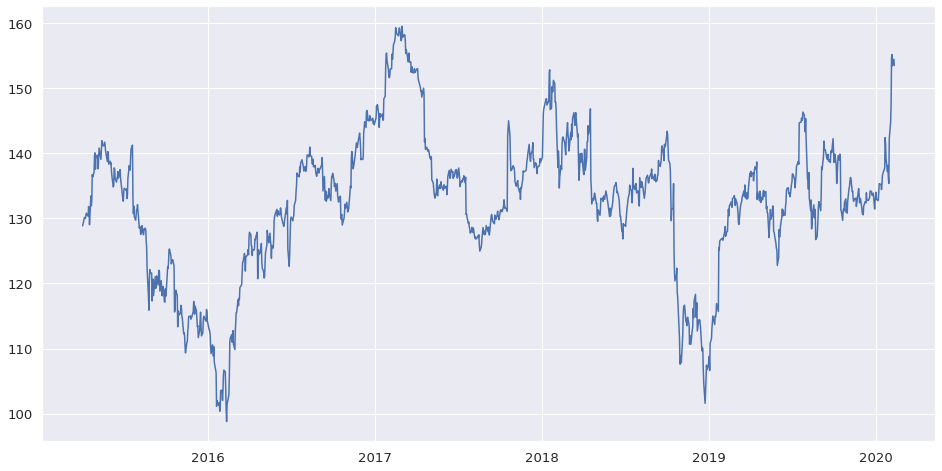

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(data['Adj Close'], label='Close Price history')
plt.show(sns)

In [0]:
def build_model_data(prices, training_days):
  x_data, y_data = [], []
  for i in range(training_days, len(prices)):
      x_data.append(prices[i - training_days:i, 0])
      y_data.append(prices[i, 0])
  x_data, y_data = np.array(x_data), np.array(y_data)
  x_data = np.reshape(x_train, (x_data.shape[0], x_data.shape[1], 1))
  return (x_train, y_train)

def build_price_model(prices, training_days=30):
  price_scaler = MinMaxScaler(feature_range=(0, 1))
  train_data = price_scaler.fit_transform(prices)

  #converting dataset into x_train and y_train
  x_train, y_train = build_input_array(train_data, training_days)

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, 
                 return_sequences=True, 
                 input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=50))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

  return model, price_scaler

In [75]:
prices = data['Adj Close'].values.reshape(-1, 1)

#set model parameters
training_days = 30
train_ratio = 0.7
train_size = (int)(len(prices) * train_ratio)

# build model with train data
model, price_scaler = build_price_model(prices[:train_size], training_days)

# build test data
test_data = price_scaler.transform(prices[train_size - training_days:])
X_test, _ = build_input_array(test_data, training_days)

# predict price using model
closing_price = price_scaler.inverse_transform(model.predict(X_test))

# calculate RMSE
rms = np.sqrt(np.mean(np.power((prices[train_size:] - closing_price), 2)))
print("RMS:{}".format(rms))


Epoch 1/2
 - 45s - loss: 0.0066
Epoch 2/2
 - 33s - loss: 0.0025
RMS:3.4968710420281734


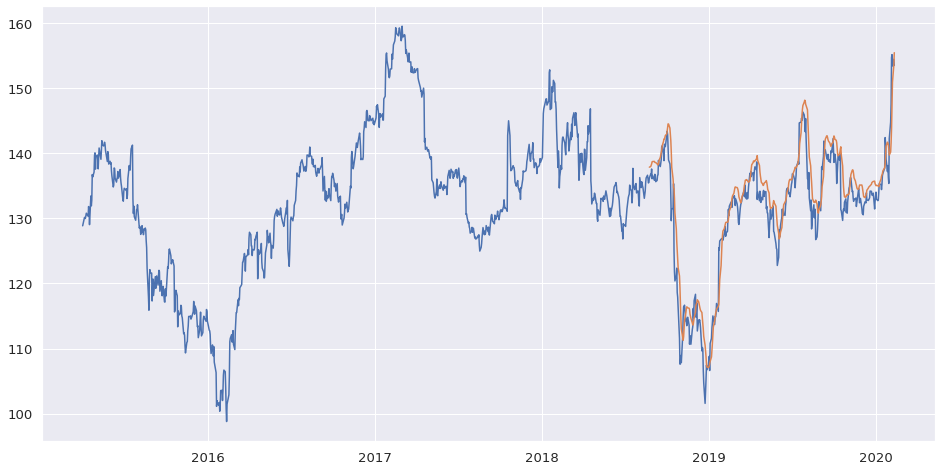

In [76]:
#for plotting
data.loc[train_size:, 'Predictions'] = closing_price[:,0]
plt.plot(data[['Adj Close','Predictions']])
plt.show()

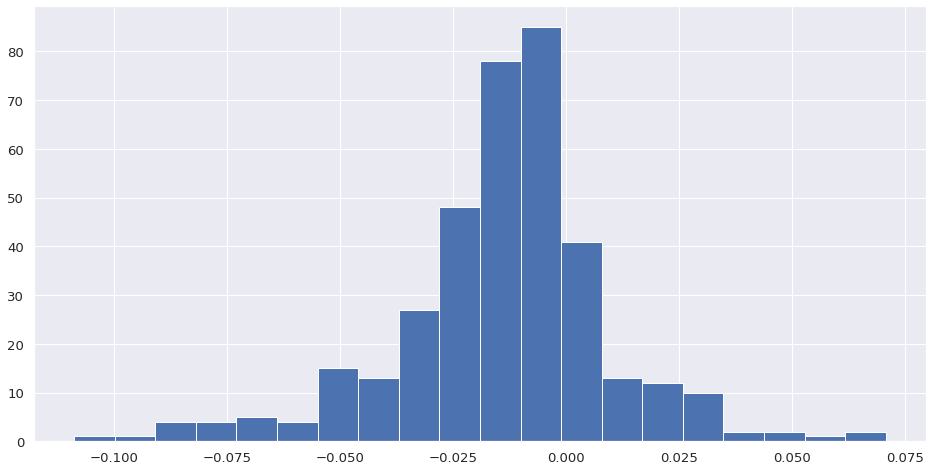

             Adj Close  Predictions      Diff
Date                                         
2018-08-24  136.181503   137.859070 -0.012319
2018-08-27  136.787628   137.951157 -0.008506
2018-08-28  136.694382   138.155396 -0.010688
2018-08-29  137.580231   138.352890 -0.005616
2018-08-30  136.078949   138.681686 -0.019127
...                ...          ...       ...
2020-02-05  154.714447   143.754410  0.070840
2020-02-06  155.139999   147.300568  0.050531
2020-02-07  153.410004   150.893814  0.016402
2020-02-10  154.429993   153.513672  0.005934
2020-02-11  153.479996   155.436417 -0.012747

[368 rows x 3 columns]


In [78]:
prediction = data[train_size:][['Adj Close', 'Predictions']]
prediction['Diff'] = (prediction['Adj Close'] - prediction['Predictions']) / prediction['Adj Close']
plt.hist(prediction.Diff, bins=20)
plt.show()
print(prediction)